# Capstone Project: Final report

## Introduction

In this notebook we will be analyzing data about crimes in Mexico city that can be found in the following link: https://datos.cdmx.gob.mx/explore/dataset/carpetas-de-investigacion-pgj-de-la-ciudad-de-mexico/map/?disjunctive.ao_hechos&disjunctive.delito. Specifically we will analyze temporal patterns to understand the hours with higher rates of criminality, find the most dangerous boroughs and neighborhoods and use this information to infer the criminal activities associated with a different venue categories.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Explore Dataset and Temporal Patterns</a>

2. <a href="#item2">Explore Neighborhoods in Mexico City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
</font>
</div>

Let´s import all required libraries

In [1]:
import os 
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

!pip install folium

In [2]:
import folium
import seaborn; seaborn.set()
import json 
from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

## 1. Explore Dataset and Temporal Patterns

In this section, we explore the dataset and select the relevant features for the study. Temporal pattern are also studied.

In [3]:
files = ['carpetas-de-investigacion-2016.csv', 'carpetas-de-investigacion-2017.csv',
        'carpetas-de-investigacion-2018.csv', 'carpetas-de-investigacion-2019.csv', 'alcaldias.geojson']

Define Credentials to access Cloud Object Storage

In [4]:
# The code was removed by Watson Studio for sharing.

In [5]:
#Define a function to download files from COS:
from ibm_botocore.client import Config
import ibm_boto3

def download_file_cos(credentials,local_file_name,key):  
    cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
    try:
        res=cos.download_file(Bucket=credentials['BUCKET'],Key=key,Filename=local_file_name)
    except Exception as e:
        print(Exception, e)
    else:
        print('File Downloaded')

In [6]:
for file in files:
    download_file_cos(credentials, file, file)

File Downloaded
File Downloaded
File Downloaded
File Downloaded
File Downloaded


In [7]:
#Read all the csv files into pandas dataframe
delitos = []
for i in range(0,4):
    delitos_año = pd.read_csv(files[i], sep=";")
    delitos.append(delitos_año)

In [8]:
#Print the total number of rows in the dataset
rows = 0
for i in range(len(delitos)):
    rows += delitos[i].shape[0]

print('Total rows: ', rows)

Total rows:  865108


In [9]:
# Put all dataframes into one
df = pd.concat(delitos)
df.reset_index(drop = True, inplace = True)
df.shape

(865108, 18)

In [10]:
#Let's visualize the first 5 rows of the dataset
pd.set_option('display.max_columns', None)
df.head()

ao_hechos  mes_hechos         fecha_hechos  \
0       2016  Septiembre  2016-09-16 12:48:00   
1       2016       Julio  2016-07-08 10:00:00   
2       2016  Septiembre  2016-09-08 00:00:00   
3       2016   Diciembre  2016-12-07 00:00:00   
4       2016       Julio  2016-07-01 12:00:00   

                                              delito        categoria_delito  \
0  DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...  DELITO DE BAJO IMPACTO   
1  FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...  DELITO DE BAJO IMPACTO   
2                                 DDH OTRAS MATERIAS      HECHO NO DELICTIVO   
3                                 DDH OTRAS MATERIAS      HECHO NO DELICTIVO   
4                        FALSIFICACION DE DOCUMENTOS  DELITO DE BAJO IMPACTO   

                                            fiscalia agencia  \
0                        INVESTIGACIÓN EN IZTAPALAPA   IZP-2   
1                          INVESTIGACIÓN EN COYOACÁN   COY-1   
2  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS FINA...       T   
3  INVESTIGACIÓN PARA LA ATENCIÓN DE DELITOS FINA...       T   
4                          INVESTIGACIÓN EN COYOACÁN   COY-3   

  unidad_investigacion      alcaldia_hechos                  colonia_hechos  \
0               UI-2SD           IZTAPALAPA                         MINERVA   
1               UI-1SD             COYOACAN                 COPILCO EL BAJO   
2               UI-1SD       MIGUEL HIDALGO  LOMAS DE CHAPULTEPEC I SECCIÓN   
3               UI-1SD           CUAUHTEMOC                        DOCTORES   
4               UI-1SD  TLALNEPANTLA DE BAZ                             NaN   

   ao_inicio  mes_inicio         fecha_inicio             calle_hechos  \
0       2019  Septiembre  2019-09-16 14:05:49                    EJE 3   
1       2019  Septiembre  2019-09-17 16:51:23     AVENIDA  UNIVERSIDAD   
2       2019  Septiembre  2019-09-17 18:13:48  BOULEVARD AVILA CAMACHO   
3       2019  Septiembre  2019-09-18 11:40:26             SE DESCONOCE   
4       2019  Septiembre  2019-09-19 13:53:06                        .   

  calle_hechos2   longitud    latitud                      geopoint  
0           NaN -99.110789  19.350066  19.3500663012,-99.1107892998  
1           NaN -99.181971  19.340739  19.3407392313,-99.1819709131  
2           NaN -99.205634  19.429673  19.4296726198,-99.2056336078  
3           NaN -99.153406  19.424215   19.424215432,-99.1534061698  
4             .        NaN        NaN                           NaN

#### Some columns are redundant and other are irrelevant for the purposes of this study. We only focus in 9 of them. Furthermore we change the names of each one of them since they are in spanish language.

In [11]:
df = df[['ao_hechos', 'mes_hechos', 'fecha_hechos',
         'delito', 'categoria_delito', 'alcaldia_hechos', 'colonia_hechos', 'longitud', 'latitud']]

df.columns = ['Year', 'Month', 'Datetime', 'Crime', 'Crime_category', 'Borough',
              'Neighborhood', 'Longitude', 'Latitude']
df.head()

Year       Month             Datetime  \
0  2016  Septiembre  2016-09-16 12:48:00   
1  2016       Julio  2016-07-08 10:00:00   
2  2016  Septiembre  2016-09-08 00:00:00   
3  2016   Diciembre  2016-12-07 00:00:00   
4  2016       Julio  2016-07-01 12:00:00   

                                               Crime          Crime_category  \
0  DAÑO EN PROPIEDAD AJENA CULPOSA POR TRÁNSITO V...  DELITO DE BAJO IMPACTO   
1  FALSIFICACION DE TITULOS AL PORTADOR Y DOCUMEN...  DELITO DE BAJO IMPACTO   
2                                 DDH OTRAS MATERIAS      HECHO NO DELICTIVO   
3                                 DDH OTRAS MATERIAS      HECHO NO DELICTIVO   
4                        FALSIFICACION DE DOCUMENTOS  DELITO DE BAJO IMPACTO   

               Borough                    Neighborhood  Longitude   Latitude  
0           IZTAPALAPA                         MINERVA -99.110789  19.350066  
1             COYOACAN                 COPILCO EL BAJO -99.181971  19.340739  
2       MIGUEL HIDALGO  LOMAS DE CHAPULTEPEC I SECCIÓN -99.205634  19.429673  
3           CUAUHTEMOC                        DOCTORES -99.153406  19.424215  
4  TLALNEPANTLA DE BAZ                             NaN        NaN        NaN

Some of the rows correspond to crimes outside Mexico city, so it´s necessary to filter out those cases and keep only crimes ocurred in boroughs of CDMX.

In [12]:
#Filter the dataset to work with the 16 boroughs in CDMX
alcaldias = ['MIGUEL HIDALGO', 'VENUSTIANO CARRANZA', 'COYOACAN', 'GUSTAVO A MADERO', 
             'TLALPAN', 'XOCHIMILCO', 'IZTACALCO', 'AZCAPOTZALCO', 'ALVARO OBREGON', 'TLAHUAC',
             'IZTAPALAPA', 'BENITO JUAREZ', 'CUAJIMALPA DE MORELOS', 'LA MAGDALENA CONTRERAS',
             'CUAUHTEMOC', 'MILPA ALTA']

#Define a function to filter the dataset
def get_boroughs(row):
    if row['Borough'] in alcaldias:
        return True
    else:
        return False

In [13]:
#Apply the function and verify that we are left with only crimes occured in Mexico City neighborhoods
df = df[df.apply(get_boroughs, axis = 1)]
df['Borough'].unique()

array(['IZTAPALAPA', 'COYOACAN', 'MIGUEL HIDALGO', 'CUAUHTEMOC',
       'GUSTAVO A MADERO', 'TLALPAN', 'BENITO JUAREZ', 'AZCAPOTZALCO',
       'VENUSTIANO CARRANZA', 'LA MAGDALENA CONTRERAS',
       'CUAJIMALPA DE MORELOS', 'TLAHUAC', 'XOCHIMILCO', 'ALVARO OBREGON',
       'IZTACALCO', 'MILPA ALTA'], dtype=object)

In [14]:
#Let´s convert the datetime column to datetime datatype
df['Datetime'] =  pd.to_datetime(df['Datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 856630 entries, 0 to 865107
Data columns (total 9 columns):
Year              856630 non-null int64
Month             856630 non-null object
Datetime          856630 non-null datetime64[ns]
Crime             856630 non-null object
Crime_category    856630 non-null object
Borough           856630 non-null object
Neighborhood      831905 non-null object
Longitude         832685 non-null float64
Latitude          832685 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 65.4+ MB


Once we have filter the dataset and select the columns we are going to be working with, let´s gain some visual insight to better understand the data.

In [15]:
df.groupby('Year').count()['Crime']

Year
2016    192421
2017    223579
2018    249051
2019    191579
Name: Crime, dtype: int64

In the next plot we can observe the number of crimes per day since january 2016 to november 2019, an increment is observed during the up to finals of 2018. After that the number of crimes decrease graduall.

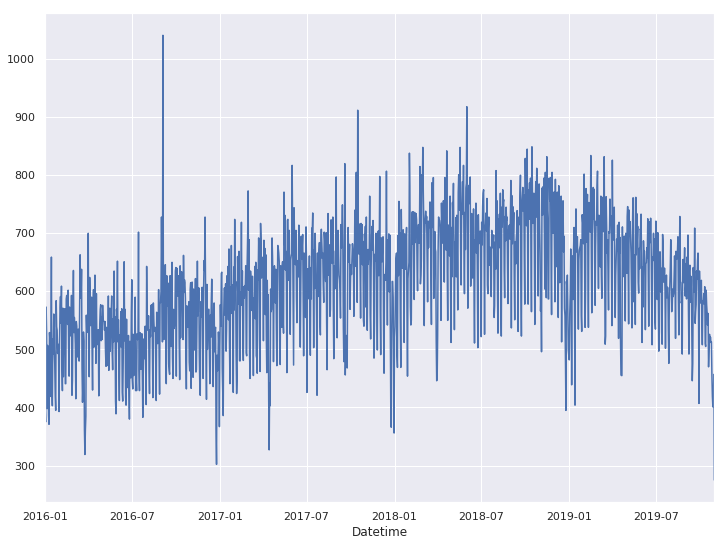

In [16]:
#Count the number of crimes per day from  2016 to 2019
crimes_per_day = df.groupby(df['Datetime'].apply(lambda x : x.date())).count()['Crime']
crimes_per_day.plot(figsize= (12,9))
plt.savefig('crimes_per_day.png', dpi =300)

In the plot below, we can observe the number of crimes 

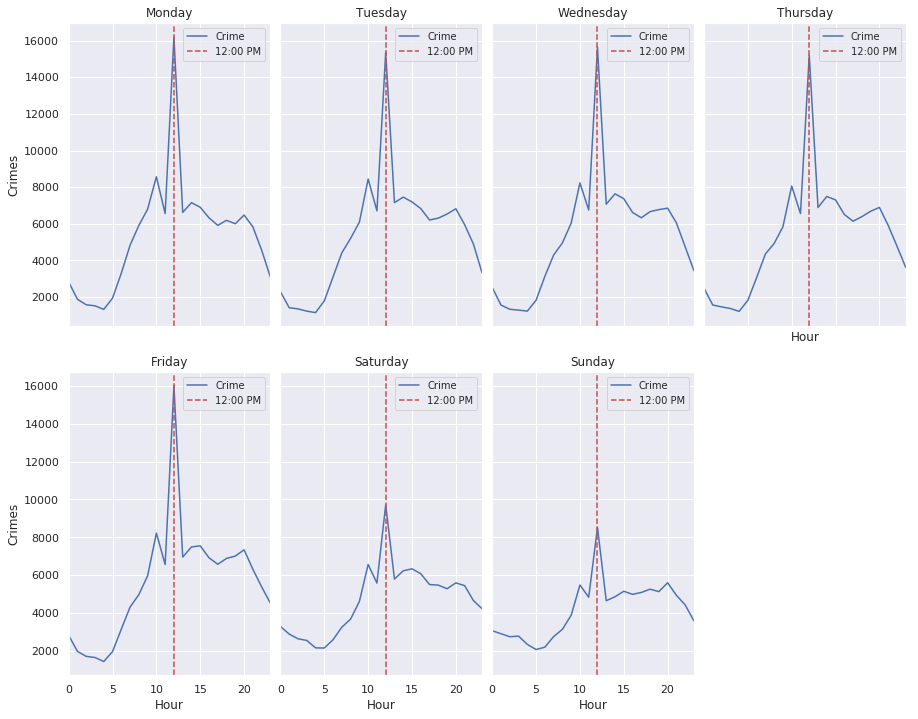

In [17]:
fig, ax = plt.subplots(2, 4, sharex = 'col', sharey = 'row', figsize = (15,12))
fig.delaxes(ax[1,3])
ax = ax.flatten()

plt.subplots_adjust(wspace=0.05, hspace=0.15)  #Remove some whitespace between subplots

for idx, d in df.groupby(df['Datetime'].dt.dayofweek):
    ax[idx].set_title(d['Datetime'].dt.day_name().iloc[0])
    d.groupby(d['Datetime'].dt.hour).count()['Crime'].plot(ax = ax[idx])
    #ax[idx].set_xticks()
    ax[idx].axvline(12,color = 'r', linestyle = '--', label = '12:00 PM')
    ax[idx].legend(fontsize = 'small')
    ax[idx].set_xlabel('Hour')
    ax[idx].set_ylabel('Crimes')

## 2. Explore Neighborhoods in Mexico City

In [18]:
#Boroughs with most crimes
crimes_per_borough = df.groupby('Borough').count()['Crime'].sort_values(ascending =False)
crimes_per_borough

Borough
CUAUHTEMOC                136604
IZTAPALAPA                130555
GUSTAVO A MADERO           86436
BENITO JUAREZ              74506
COYOACAN                   58033
ALVARO OBREGON             57469
MIGUEL HIDALGO             57280
VENUSTIANO CARRANZA        50168
TLALPAN                    49681
AZCAPOTZALCO               41881
IZTACALCO                  36854
XOCHIMILCO                 26374
TLAHUAC                    19907
LA MAGDALENA CONTRERAS     13043
CUAJIMALPA DE MORELOS      12198
MILPA ALTA                  5641
Name: Crime, dtype: int64

The map below shows the number of crimes in each neighborhood

In [19]:
cdmx_map = folium.Map(location=(19.432241, -99.177254), zoom_start=10)
folium.Choropleth(geo_data = 'alcaldias.geojson',
                 data=crimes_per_borough,
                 columns=[crimes_per_borough.index, crimes_per_borough.values],
                 key_on= 'feature.properties.nomgeo',
                 fill_color='YlOrRd',
                 fill_opacity=0.5,
                 line_opacity=0.5,
                 ).add_to(cdmx_map)
cdmx_map.save('cdmx.html')
cdmx_map

In [20]:
#A new column is created to make easier working with the dataset
df['crime_scene'] = df['Borough'] + " " + df['Neighborhood']
df['crime_scene']

0                                        IZTAPALAPA MINERVA
1                                  COYOACAN COPILCO EL BAJO
2             MIGUEL HIDALGO LOMAS DE CHAPULTEPEC I SECCIÓN
3                                       CUAUHTEMOC DOCTORES
5                        GUSTAVO A MADERO TORRES LINDAVISTA
6                             TLALPAN SAN ANDRÉS TOTOLTEPEC
7                                                       NaN
8                                                       NaN
9                                                       NaN
10                                      CUAUHTEMOC ROMA SUR
11                                     BENITO JUAREZ ÁLAMOS
13                               IZTAPALAPA BENITO JUAREZ I
14                                                      NaN
15                               AZCAPOTZALCO SANTO DOMINGO
17                         VENUSTIANO CARRANZA ROMERO RUBIO
18                                                      NaN
19                                  COYO

In [21]:
#Only crimes related to some keywords are used in the analysis
crime_types = df['Crime'].value_counts()

filtered_crimes = []
keywords = ['ROBO', 'VIOLENCIA', 'NARCOMENUDEO', 'VIOLACION', 'HOMICIDIO', 'EXTORSION', 'INTIMIDACION',
           'SECUESTRO', 'PRIVACION', 'FEMINICIDIO']
for delito in list(crime_types.index):
    for word in keywords:
        if (delito.find(word) != -1):
            filtered_crimes.append(delito)
filtered_crimes

['VIOLENCIA FAMILIAR',
 'ROBO A NEGOCIO SIN VIOLENCIA',
 'ROBO A NEGOCIO SIN VIOLENCIA',
 'ROBO DE OBJETOS',
 'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA',
 'ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA',
 'ROBO DE ACCESORIOS DE AUTO',
 'ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO',
 'ROBO A CASA HABITACION SIN VIOLENCIA',
 'ROBO A CASA HABITACION SIN VIOLENCIA',
 'ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA',
 'ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A NEGOCIO CON VIOLENCIA',
 'ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA',
 'ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA',
 'NARCOMENUDEO POSESION SIMPLE',
 'ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA',
 'ROBO A TRANSEUNTE DE CELULAR SIN VIOLENCIA',
 'ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA',
 'ROBO A PASAJERO / CONDUCTOR DE VEHICULO CON VIOLENCIA',
 'ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VIOLENCIA',
 'ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VIOLE

In [22]:
#Remove "Violencia Familiar" since this is not relevant for our purposes 
filtered_crimes.pop(0)
crime_types = crime_types[filtered_crimes]
crime_types

ROBO A NEGOCIO SIN VIOLENCIA                                    57401
ROBO A NEGOCIO SIN VIOLENCIA                                    57401
ROBO DE OBJETOS                                                 55067
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA                  46526
ROBO A TRANSEUNTE EN VIA PUBLICA CON VIOLENCIA                  46526
ROBO DE ACCESORIOS DE AUTO                                      26812
ROBO DE OBJETOS DEL INTERIOR DE UN VEHICULO                     25296
ROBO A CASA HABITACION SIN VIOLENCIA                            23788
ROBO A CASA HABITACION SIN VIOLENCIA                            23788
ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA           23218
ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VIOLENCIA           23218
ROBO A NEGOCIO CON VIOLENCIA                                    14445
ROBO A NEGOCIO CON VIOLENCIA                                    14445
ROBO A TRANSEUNTE DE CELULAR CON VIOLENCIA                      13966
ROBO A TRANSEUNTE DE

In [23]:
def category_filter(row):
    if row['Crime'] in crime_types.index:
        return True
    else:
        return False

In [24]:
#Filter the dataset based on the keywords defined 
crimes = df.apply(category_filter, axis = 1)
df = df[crimes]
df.reset_index(drop=True, inplace = True)
df.head()

Year       Month            Datetime  \
0  2016  Septiembre 2016-09-27 22:30:00   
1  2016        Mayo 2016-05-09 10:00:00   
2  2016        Mayo 2016-05-20 22:30:00   
3  2016   Diciembre 2016-12-31 22:11:00   
4  2016   Diciembre 2016-12-31 19:55:00   

                                               Crime  \
0  ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...   
1                                    ROBO DE OBJETOS   
2                                          VIOLACION   
3  HOMICIDIO CULPOSO POR TRÁNSITO VEHICULAR (ATRO...   
4  ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...   

                         Crime_category                Borough  \
0  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA          BENITO JUAREZ   
1                DELITO DE BAJO IMPACTO           AZCAPOTZALCO   
2                             VIOLACIÓN  CUAJIMALPA DE MORELOS   
3                DELITO DE BAJO IMPACTO                TLAHUAC   
4  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA             IZTAPALAPA   

         Neighborhood  Longitude   Latitude                        crime_scene  
0              ÁLAMOS -99.144716  19.399571               BENITO JUAREZ ÁLAMOS  
1           PRO-HOGAR -99.158316  19.475116             AZCAPOTZALCO PRO-HOGAR  
2         CRUZ BLANCA -99.319987  19.326170  CUAJIMALPA DE MORELOS CRUZ BLANCA  
3  SANTA ANA PONIENTE -99.053535  19.302084         TLAHUAC SANTA ANA PONIENTE  
4       UNIDAD MODELO -99.128550  19.363062           IZTAPALAPA UNIDAD MODELO

In [25]:
df.shape

(439992, 10)

In [26]:
# Neighborhoods with most crimes
crimes_per_neighborhood = df.groupby('crime_scene').count()['Crime'].sort_values(ascending =False)
crimes_per_neighborhood

crime_scene
CUAUHTEMOC CENTRO                                        15906
BENITO JUAREZ DEL VALLE CENTRO                            6404
CUAUHTEMOC ROMA NORTE                                     6173
BENITO JUAREZ NARVARTE                                    5685
CUAUHTEMOC BUENAVISTA                                     4870
CUAUHTEMOC DOCTORES                                       4710
CUAUHTEMOC GUERRERO                                       4216
IZTAPALAPA CENTRAL DE ABASTO                              3952
IZTACALCO AGRÍCOLA ORIENTAL                               3800
CUAUHTEMOC JUÁREZ                                         3787
MIGUEL HIDALGO POLANCO                                    3735
IZTACALCO AGRÍCOLA PANTITLAN                              3331
CUAUHTEMOC SANTA MARIA LA RIBERA                          3078
BENITO JUAREZ PORTALES SUR                                2716
MIGUEL HIDALGO ANAHUAC                                    2699
CUAUHTEMOC MORELOS                         

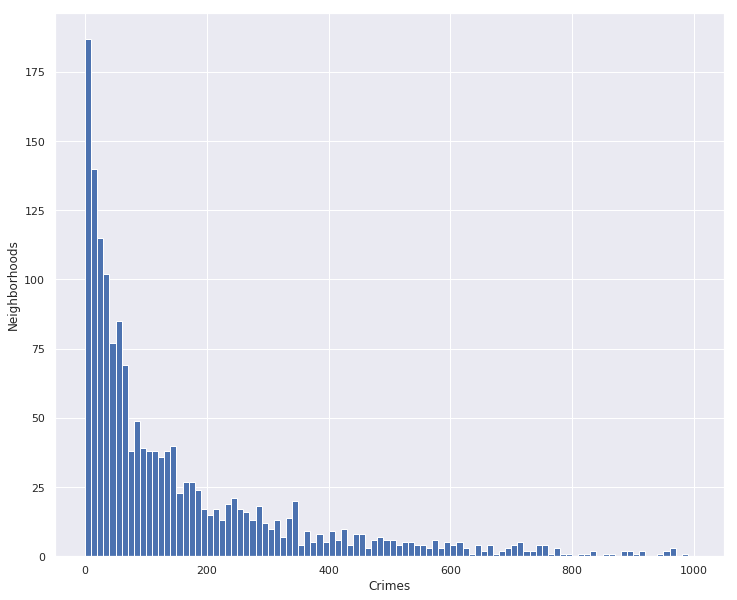

In [27]:
#The histogram allows us to see the number og neighborhoods with a certain number of crimes
plt.figure(figsize = (12,10))
plt.hist(crimes_per_neighborhood.values, bins=100, range= (0,1000))
plt.xlabel('Crimes')
plt.ylabel('Neighborhoods')
plt.show()

In [28]:
crimes_per_neighborhood.describe()

count     1734.000000
mean       251.659170
std        627.270167
min          1.000000
25%         28.250000
50%         91.000000
75%        252.750000
max      15906.000000
Name: Crime, dtype: float64

In [29]:
#Based on the histogram above, we want to only keep neighborhoods with having more than 200 crimes   
dangerous_neighborhoods = crimes_per_neighborhood >= 200
dangerous_neighborhoods = dangerous_neighborhoods.reset_index()
dangerous_neighborhoods

crime_scene  Crime
0                                     CUAUHTEMOC CENTRO   True
1                        BENITO JUAREZ DEL VALLE CENTRO   True
2                                 CUAUHTEMOC ROMA NORTE   True
3                                BENITO JUAREZ NARVARTE   True
4                                 CUAUHTEMOC BUENAVISTA   True
5                                   CUAUHTEMOC DOCTORES   True
6                                   CUAUHTEMOC GUERRERO   True
7                          IZTAPALAPA CENTRAL DE ABASTO   True
8                           IZTACALCO AGRÍCOLA ORIENTAL   True
9                                     CUAUHTEMOC JUÁREZ   True
10                               MIGUEL HIDALGO POLANCO   True
11                         IZTACALCO AGRÍCOLA PANTITLAN   True
12                     CUAUHTEMOC SANTA MARIA LA RIBERA   True
13                           BENITO JUAREZ PORTALES SUR   True
14                               MIGUEL HIDALGO ANAHUAC   True
15                                   CUAUHTEMOC MORELOS   True
16                      BENITO JUAREZ SANTA CRUZ ATOYAC   True
17                   GUSTAVO A MADERO GUADALUPE TEPEYAC   True
18                                    CUAUHTEMOC OBRERA   True
19                          GUSTAVO A MADERO LINDAVISTA   True
20                                  CUAUHTEMOC ROMA SUR   True
21                                MIGUEL HIDALGO TACUBA   True
22                  VENUSTIANO CARRANZA JARDÍN BALBUENA   True
23                                 CUAUHTEMOC HIPÓDROMO   True
24                      VENUSTIANO CARRANZA ZONA CENTRO   True
25                              MIGUEL HIDALGO TACUBAYA   True
26                              AZCAPOTZALCO EL ROSARIO   True
27                                 BENITO JUAREZ ÁLAMOS   True
28                             IZTACALCO GRANJAS MÉXICO   True
29            IZTAPALAPA DESARROLLO URBANO QUETZALCOATL   True
...                                                 ...    ...
1704                      TLALPAN JARDINES DEL PEDREGAL  False
1705            IZTAPALAPA BARRIO SAN ANTONIO CULHUACÁN  False
1706                                XOCHIMILCO TEPEYECA  False
1707             LA MAGDALENA CONTRERAS CERRO DEL JUDIO  False
1708                  TLAHUAC ZONA DE RESERVA ECOLOGICA  False
1709                   ALVARO OBREGON CAÑADA DEL OLIVAR  False
1710           LA MAGDALENA CONTRERAS TORRES DE POTRERO  False
1711                    IZTAPALAPA CABEZA DE JUAREZ III  False
1712                                 TLAHUAC TEZONTITLA  False
1713         TLAHUAC SANTA MARIA DE LOS OLIVOS - BARRIO  False
1714                    GUSTAVO A MADERO QUETZALCOATL 3  False
1715                                 TLALPAN PERIFÉRICO  False
1716                         COYOACAN VISTAS DEL MAUREL  False
1717                        ALVARO OBREGON ZONA FEDERAL  False
1718                  TLALPAN PEDREGAL DE SANTO DOMINGO  False
1719  ALVARO OBREGON BELEN DE LAS FLORES SECCION ORI...  False
1720  ALVARO OBREGON BELEN DE LAS FLORES SECCION PAB...  False
1721                     IZTAPALAPA CABEZA DE JUAREZ II  False
1722                         ALVARO OBREGON TEMPRANILLO  False
1723                    XOCHIMILCO RESIDENCIAL SANTIAGO  False
1724  ALVARO OBREGON BELEN DE LAS FLORES SECCION TUR...  False
1725                             XOCHIMILCO MANANTIALES  False
1726     ALVARO OBREGON SAN AGUSTÍN DEL PUEBLO TETELPAN  False
1727                               XOCHIMILCO SAN DIEGO  False
1728                   GUSTAVO A MADERO VISTA HERMOSA I  False
1729                             ALVARO OBREGON BOSCOSO  False
1730              GUSTAVO A MADERO SAN MIGUEL 1 SECCION  False
1731                                     XOCHIMILCO DIF  False
1732                             COYOACAN SECTOR MARINA  False
1733                            TLALPAN VILLA VALBADENA  False

[1734 rows x 2 columns]

In [30]:
#Define the list of neighborhoods with more than 200 crimes
dangerous_neighborhoods = dangerous_neighborhoods[dangerous_neighborhoods['Crime'] == True].reset_index(drop =True)
dn = dangerous_neighborhoods['crime_scene']
dn = dn.tolist()
dn

['CUAUHTEMOC CENTRO',
 'BENITO JUAREZ DEL VALLE CENTRO',
 'CUAUHTEMOC ROMA NORTE',
 'BENITO JUAREZ NARVARTE',
 'CUAUHTEMOC BUENAVISTA',
 'CUAUHTEMOC DOCTORES',
 'CUAUHTEMOC GUERRERO',
 'IZTAPALAPA CENTRAL DE ABASTO',
 'IZTACALCO AGRÍCOLA ORIENTAL',
 'CUAUHTEMOC JUÁREZ',
 'MIGUEL HIDALGO POLANCO',
 'IZTACALCO AGRÍCOLA PANTITLAN',
 'CUAUHTEMOC SANTA MARIA LA RIBERA',
 'BENITO JUAREZ PORTALES SUR',
 'MIGUEL HIDALGO ANAHUAC',
 'CUAUHTEMOC MORELOS',
 'BENITO JUAREZ SANTA CRUZ ATOYAC',
 'GUSTAVO A MADERO GUADALUPE TEPEYAC',
 'CUAUHTEMOC OBRERA',
 'GUSTAVO A MADERO LINDAVISTA',
 'CUAUHTEMOC ROMA SUR',
 'MIGUEL HIDALGO TACUBA',
 'VENUSTIANO CARRANZA JARDÍN BALBUENA',
 'CUAUHTEMOC HIPÓDROMO',
 'VENUSTIANO CARRANZA ZONA CENTRO',
 'MIGUEL HIDALGO TACUBAYA',
 'AZCAPOTZALCO EL ROSARIO',
 'BENITO JUAREZ ÁLAMOS',
 'IZTACALCO GRANJAS MÉXICO',
 'IZTAPALAPA DESARROLLO URBANO QUETZALCOATL',
 'BENITO JUAREZ NAPOLES',
 'COYOACAN PEDREGAL DE SANTO DOMINGO',
 'CUAUHTEMOC CUAUHTÉMOC',
 'IZTAPALAPA SANTA CRUZ 

In [31]:
#Filter the original dataset and create a new one with the selected neighborhoods
df2 = df[df['crime_scene'].isin(dn)].reset_index(drop =True)
df2.head()

Year       Month            Datetime  \
0  2016  Septiembre 2016-09-27 22:30:00   
1  2016        Mayo 2016-05-09 10:00:00   
2  2016   Diciembre 2016-12-31 22:11:00   
3  2016   Diciembre 2016-12-31 19:55:00   
4  2016   Diciembre 2016-12-31 05:50:00   

                                               Crime  \
0  ROBO DE VEHICULO DE SERVICIO PARTICULAR SIN VI...   
1                                    ROBO DE OBJETOS   
2  HOMICIDIO CULPOSO POR TRÁNSITO VEHICULAR (ATRO...   
3  ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...   
4                                    ROBO DE OBJETOS   

                         Crime_category        Borough        Neighborhood  \
0  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  BENITO JUAREZ              ÁLAMOS   
1                DELITO DE BAJO IMPACTO   AZCAPOTZALCO           PRO-HOGAR   
2                DELITO DE BAJO IMPACTO        TLAHUAC  SANTA ANA PONIENTE   
3  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA     IZTAPALAPA       UNIDAD MODELO   
4                DELITO DE BAJO IMPACTO     IZTAPALAPA         LOS ÁNGELES   

   Longitude   Latitude                 crime_scene  
0 -99.144716  19.399571        BENITO JUAREZ ÁLAMOS  
1 -99.158316  19.475116      AZCAPOTZALCO PRO-HOGAR  
2 -99.053535  19.302084  TLAHUAC SANTA ANA PONIENTE  
3 -99.128550  19.363062    IZTAPALAPA UNIDAD MODELO  
4 -99.073220  19.350219      IZTAPALAPA LOS ÁNGELES

In [32]:
neighborhoods = df2.groupby('crime_scene').count()[['Crime']].sort_values(by = 'Crime' ,ascending =False).reset_index()
neighborhoods.head()

crime_scene  Crime
0               CUAUHTEMOC CENTRO  15906
1  BENITO JUAREZ DEL VALLE CENTRO   6404
2           CUAUHTEMOC ROMA NORTE   6173
3          BENITO JUAREZ NARVARTE   5685
4           CUAUHTEMOC BUENAVISTA   4870

In [33]:
coordinates = df2.groupby('crime_scene')[['Longitude', 
                    'Latitude']].apply(lambda x: x.head(1)).reset_index().drop('level_1', axis =1)
coordinates.head()

crime_scene  Longitude   Latitude
0                   ALVARO OBREGON ACUEDUCTO -99.200462  19.398390
1                ALVARO OBREGON ALFONSO XIII -99.195677  19.374639
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS -99.196510  19.372236
3                ALVARO OBREGON BARRIO NORTE -99.204578  19.379006
4                  ALVARO OBREGON BELLAVISTA -99.193610  19.395849

In [34]:
#Define a new dataframe to be used in making folium map
dn_coords = pd.merge(neighborhoods, coordinates, on = ['crime_scene'])
dn_coords.head()

crime_scene  Crime  Longitude   Latitude
0               CUAUHTEMOC CENTRO  15906 -99.137663  19.433659
1  BENITO JUAREZ DEL VALLE CENTRO   6404 -99.167536  19.382243
2           CUAUHTEMOC ROMA NORTE   6173 -99.162078  19.415845
3          BENITO JUAREZ NARVARTE   5685 -99.149469  19.394186
4           CUAUHTEMOC BUENAVISTA   4870 -99.149521  19.445691

In [35]:
#Create a map of the most dangerous neighborhoods 
import branca.colormap as cm
colormap = cm.linear.YlOrRd_04.scale(dn_coords['Crime'].min(), dn_coords['Crime'].max())
dn_map = folium.Map(location=(19.432241, -99.177254), tiles='cartodbdark_matter', zoom_start=11, 
                    control_scale= True)
folium.Choropleth(geo_data = 'alcaldias.geojson',
                 fill_color='r',
                 fill_opacity=0.0,
                 line_opacity=1.0,
                 line_color = 'yellow',
                 line_weight = 0.5
                 ).add_to(dn_map)

for lat, lon, name, no_crimes in zip(dn_coords['Latitude'], dn_coords['Longitude'],
                                    dn_coords['crime_scene'], dn_coords['Crime']):
    folium.CircleMarker(
        [lat, lon],
        radius=.001*no_crimes,
        popup = ('Neighborhood: ' + str(name).capitalize() + '<br>'
                 'No.Crimes: ' + str(no_crimes) + '<br>'),
        color= colormap(no_crimes),
        key_on = no_crimes,
        fill=True,
        fill_opacity=1.0
        ).add_to(dn_map)
dn_map.save('dn_map.html')
dn_map

In [36]:
#Define a new dataframe containing information about crimes commited in each neighborhood
dn_onehot = pd.get_dummies(df2[['Crime_category']], prefix="", prefix_sep="")
dn_onehot['crime_scene'] = df2['crime_scene']

fixed_columns = [dn_onehot.columns[-1]] + list(dn_onehot.columns[:-1])
dn_onehot = dn_onehot[fixed_columns]
dn_onehot.head()

crime_scene  DELITO DE BAJO IMPACTO  HECHO NO DELICTIVO  \
0        BENITO JUAREZ ÁLAMOS                       0                   0   
1      AZCAPOTZALCO PRO-HOGAR                       1                   0   
2  TLAHUAC SANTA ANA PONIENTE                       1                   0   
3    IZTAPALAPA UNIDAD MODELO                       0                   0   
4      IZTAPALAPA LOS ÁNGELES                       1                   0   

   HOMICIDIO DOLOSO  ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                 0                                     0   
1                 0                                     0   
2                 0                                     0   
3                 0                                     0   
4                 0                                     0   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                             0   
1                             0   
2                             0   
3                             0   
4                             0   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
0                                      0   
1                                      0   
2                                      0   
3                                      0   
4                                      0   

   ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  
0                                     1          0          0  
1                                     0          0          0  
2                                     0          0          0  
3                                     1          0          0  
4                                     0          0          0

In [37]:
#Dataframe to be used in training the clustering algorithm
dn_grouped =  dn_onehot.groupby('crime_scene').mean().reset_index()
dn_grouped.head()

crime_scene  DELITO DE BAJO IMPACTO  \
0                   ALVARO OBREGON ACUEDUCTO                0.618297   
1                ALVARO OBREGON ALFONSO XIII                0.658291   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS                0.667263   
3                ALVARO OBREGON BARRIO NORTE                0.668508   
4                  ALVARO OBREGON BELLAVISTA                0.650124   

   HECHO NO DELICTIVO  HOMICIDIO DOLOSO  ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                 0.0          0.003155                              0.000000   
1                 0.0          0.005025                              0.001675   
2                 0.0          0.010733                              0.003578   
3                 0.0          0.049724                              0.000000   
4                 0.0          0.027295                              0.009926   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                      0.003155   
1                      0.028476   
2                      0.033989   
3                      0.019337   
4                      0.004963   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                           0.006309         
1                                           0.000000         
2                                           0.000000         
3                                           0.002762         
4                                           0.012407         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                       0.006309   
1                                       0.001675   
2                                       0.005367   
3                                       0.011050   
4                                       0.007444   

   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
0                                           0.148265       
1                                           0.000000       
2                                           0.000000       
3                                           0.000000       
4                                           0.000000       

   ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
0                               0.003155   
1                               0.011725   
2                               0.010733   
3                               0.038674   
4                               0.004963   

   ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
0                                           0.148265      
1                                           0.093802      
2                                           0.101968      
3                                           0.151934      
4                                           0.151365      

   ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  
0                              0.053628        0.0   0.009464  
1                              0.197655        0.0   0.001675  
2                              0.166369        0.0   0.000000  
3                              0.055249        0.0   0.002762  
4                              0.121588        0.0   0.009926

## 3. Analyze Each Neighborhood

### Define Foursquare credentials 

In [38]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: EYVFV40BHFROPM5BHA3ASZV34ALRDQ0HYW1NNQPVLQI3LJED
CLIENT_SECRET:XGOR11WRUBTTYDF0JL4C2G1CLRFAMHC2DUDBTCCNTTECY0TQ


In [39]:
#This is just a test
neighborhood_latitude = dn_coords.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dn_coords.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = dn_coords.loc[0, 'crime_scene'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of CUAUHTEMOC CENTRO are 19.433659279581303, -99.1376626488613.


In [40]:
LIMIT = 100
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=EYVFV40BHFROPM5BHA3ASZV34ALRDQ0HYW1NNQPVLQI3LJED&client_secret=XGOR11WRUBTTYDF0JL4C2G1CLRFAMHC2DUDBTCCNTTECY0TQ&v=20191210&ll=19.433659279581303,-99.1376626488613&radius=500&limit=100'

In [41]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5df7bc0f71782e001be0280b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Centro',
  'headerFullLocation': 'Centro, Mexico City',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 232,
  'suggestedBounds': {'ne': {'lat': 19.43815928408131,
    'lng': -99.13289968793639},
   'sw': {'lat': 19.429159275081297, 'lng': -99.1424256097862}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55f476fe498e26410387a491',
       'name': 'Hotel Historico Central',
       'location': {'address': 'Bolívar 28',
        'crossStreet': 'Francisco y Madero',
        'lat': 19.433152805337038,
        'lng': -99.13837610874903,
        'labeledLatLng

In [42]:
venues = results['response']['groups'][0]['items']
len(venues)

100

In [43]:
nearby_venues = json_normalize(venues)
nearby_venues.head()

reasons.count                                      reasons.items  \
0              0  [{'summary': 'This spot is popular', 'type': '...   
1              0  [{'summary': 'This spot is popular', 'type': '...   
2              0  [{'summary': 'This spot is popular', 'type': '...   
3              0  [{'summary': 'This spot is popular', 'type': '...   
4              0  [{'summary': 'This spot is popular', 'type': '...   

                       referralId  \
0  e-0-55f476fe498e26410387a491-0   
1  e-0-4eb83dfb4901cef9d9b877ba-1   
2  e-0-4ccdce6354f0b1f708d51eca-2   
3  e-0-4d30c072f986a093498fff66-3   
4  e-0-4b33388bf964a520281825e3-4   

                                    venue.categories  venue.events.count  \
0  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...                 NaN   
1  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...                 NaN   
2  [{'id': '4bf58dd8d48988d150941735', 'name': 'S...                 NaN   
3  [{'id': '4bf58dd8d48988d18f941735', 'name': 'A...                 NaN   
4  [{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...                 NaN   

  venue.events.summary                  venue.id  venue.location.address  \
0                  NaN  55f476fe498e26410387a491              Bolívar 28   
1                  NaN  4eb83dfb4901cef9d9b877ba   Isabel la Católica 30   
2                  NaN  4ccdce6354f0b1f708d51eca   Isabel la Católica 29   
3                  NaN  4d30c072f986a093498fff66  Francisco I. Madero 17   
4                  NaN  4b33388bf964a520281825e3            Motolinia 20   

  venue.location.cc venue.location.city venue.location.country  \
0                MX    Ciudad de México                 México   
1                MX          Cuauhtemoc                 México   
2                MX          Cuauhtemoc                 México   
3                MX          Cuauhtemoc                 México   
4                MX          Cuauhtemoc                 México   

  venue.location.crossStreet  venue.location.distance  \
0         Francisco y Madero                       93   
1                        NaN                      175   
2        Francisco I. Madero                       91   
3      Entre Gante y Bolívar                      142   
4                  5 de Mayo                       87   

                     venue.location.formattedAddress  \
0  [Bolívar 28 (Francisco y Madero), 06000 Ciudad...   
1  [Isabel la Católica 30, 06000 Cuauhtemoc, Dist...   
2  [Isabel la Católica 29 (Francisco I. Madero), ...   
3  [Francisco I. Madero 17 (Entre Gante y Bolívar...   
4  [Motolinia 20 (5 de Mayo), 06050 Cuauhtémoc, D...   

                       venue.location.labeledLatLngs  venue.location.lat  \
0  [{'label': 'display', 'lat': 19.43315280533703...           19.433153   
1  [{'label': 'display', 'lat': 19.43287468676530...           19.432875   
2  [{'label': 'display', 'lat': 19.43302288006536...           19.433023   
3  [{'label': 'display', 'lat': 19.43368069930011...           19.433681   
4  [{'label': 'display', 'lat': 19.43425132862883...           19.434251   

   venue.location.lng venue.location.neighborhood venue.location.postalCode  \
0          -99.138376                    Downtown                     06000   
1          -99.136208                         NaN                     06000   
2          -99.137110                         NaN                     06000   
3          -99.139018                         NaN                     06000   
4          -99.137114                    Downtown                     06050   

  venue.location.state                                         venue.name  \
0     Distrito Federal                            Hotel Historico Central   
1     Distrito Federal                                    Downtown México   
2     Distrito Federal                                     Casino Español   
3     Distrito Federal  Palacio de Cultura Banamex - Antiguo Palacio d...   
4     Distrito Federal                       

In [44]:
#Define a function to extract the venue categories. Taken from the course notebook
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [45]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name          categories  \
0                            Hotel Historico Central               Hotel   
1                                    Downtown México               Hotel   
2                                     Casino Español  Spanish Restaurant   
3  Palacio de Cultura Banamex - Antiguo Palacio d...          Art Museum   
4                                    Zinco Jazz Club           Jazz Club   

         lat        lng  
0  19.433153 -99.138376  
1  19.432875 -99.136208  
2  19.433023 -99.137110  
3  19.433681 -99.139018  
4  19.434251 -99.137114

In [46]:
#This function extracts all venue categories for each neighborhood
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [47]:
#Save the venues into a new dataframe
#cdmx_venues = getNearbyVenues(names=dn_coords['crime_scene'],
 #                                  latitudes=dn_coords['Latitude'],
  #                                 longitudes=dn_coords['Longitude']
   #                               )

In [48]:
#Save the dataframe into a csv file. This is done because Foursquare API only allows to make less than 1000 regular calls
#cdmx_venues.to_csv("cdmx_venues")
download_file_cos(credentials, 'cdmx_venues', 'cdmx_venues')
cdmx_venues= pd.read_csv('cdmx_venues', index_col= 0)

File Downloaded


In [49]:
#Define a similar dataframe to dn_onehot
venues_onehot = pd.get_dummies(cdmx_venues[['Venue Category']], prefix="", prefix_sep="")
venues_onehot['crime_scene'] = cdmx_venues['Neighborhood']

fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

venues_onehot.head()

crime_scene  ATM  Accessories Store  Advertising Agency  \
0  CUAUHTEMOC CENTRO    0                  0                   0   
1  CUAUHTEMOC CENTRO    0                  0                   0   
2  CUAUHTEMOC CENTRO    0                  0                   0   
3  CUAUHTEMOC CENTRO    0                  0                   0   
4  CUAUHTEMOC CENTRO    0                  0                   0   

   African Restaurant  Airport  Airport Food Court  Airport Gate  \
0                   0        0                   0             0   
1                   0        0                   0             0   
2                   0        0                   0             0   
3                   0        0                   0             0   
4                   0        0                   0             0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  Arcade  Arepa Restaurant  Argentinian Restaurant  \
0             0         0       0                 0                       0   
1             0         0       0                 0                       0   
2             0         0       0                 0                       0   
3             0         0       0                 0                       0   
4             0         0       0                 0                       0   

   Art Gallery  Art Museum  Arts & Crafts Store  Arts & Entertainment  \
0            0           0                    0                     0   
1            0           0                    0                     0   
2            0           0                    0                     0   
3            0           1                    0                     0   
4            0           0                    0                     0   

   Asian Restaurant  Athletics & Sports  Australian Restaurant  \
0                 0                   0                      0   
1                 0                   0                      0   
2                 0                   0                      0   
3                 0                   0                      0   
4                 0                   0                      0   

   Auto Dealership  Auto Garage  Auto Workshop  Automotive Shop  BBQ Joint  \
0                0            0              0                0          0   
1                0            0              0                0          0   
2                0            0              0                0          0   
3                0            0              0                0          0   
4                0            0              0                0          0   

   Baby Store  Bagel Shop  Bakery  Bank  Bar  Baseball Field  \
0           0           0       0     0    0               0   
1           0           0       0     0    0               0   
2           0           0       0     0    0               0   
3           0           0       0     0    0               0   
4           0           0       0     0    0               0   

   Baseball Stadium  Basketball Court  Basketball Stadium  Bathing Area  \
0                 0                 0                   0             0   
1                 0                 0                   0             0   
2                 0                 0                   0             0   
3                 0                 0                   0             0   
4                 0                 0                   0             0   

   Bed & Breakfast  Beer Bar  Beer Garden  Beer Store  Belgian Restaurant  \
0                0         0       

In [50]:
venues_grouped = venues_onehot.groupby('crime_scene').mean().reset_index()
venues_grouped.head()

crime_scene  ATM  Accessories Store  \
0                   ALVARO OBREGON ACUEDUCTO  0.0           0.000000   
1                ALVARO OBREGON ALFONSO XIII  0.0           0.000000   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS  0.0           0.000000   
3                ALVARO OBREGON BARRIO NORTE  0.0           0.000000   
4                  ALVARO OBREGON BELLAVISTA  0.0           0.041667   

   Advertising Agency  African Restaurant  Airport  Airport Food Court  \
0                 0.0                 0.0      0.0                 0.0   
1                 0.0                 0.0      0.0                 0.0   
2                 0.0                 0.0      0.0                 0.0   
3                 0.0                 0.0      0.0                 0.0   
4                 0.0                 0.0      0.0                 0.0   

   Airport Gate  Airport Lounge  Airport Service  Airport Terminal  \
0           0.0             0.0              0.0               0.0   
1           0.0             0.0              0.0               0.0   
2           0.0             0.0              0.0               0.0   
3           0.0             0.0              0.0               0.0   
4           0.0             0.0              0.0               0.0   

   American Restaurant  Antique Shop  Aquarium  Arcade  Arepa Restaurant  \
0                  0.0           0.0       0.0     0.0               0.0   
1                  0.0           0.0       0.0     0.0               0.0   
2                  0.0           0.0       0.0     0.0               0.0   
3                  0.0           0.0       0.0     0.0               0.0   
4                  0.0           0.0       0.0     0.0               0.0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                     0.0          0.0         0.0             0.000000   
1                     0.0          0.0         0.0             0.000000   
2                     0.0          0.0         0.0             0.000000   
3                     0.0          0.0         0.0             0.000000   
4                     0.0          0.0         0.0             0.041667   

   Arts & Entertainment  Asian Restaurant  Athletics & Sports  \
0                   0.0               0.0            0.000000   
1                   0.0               0.0            0.000000   
2                   0.0               0.0            0.019231   
3                   0.0               0.0            0.000000   
4                   0.0               0.0            0.000000   

   Australian Restaurant  Auto Dealership  Auto Garage  Auto Workshop  \
0                    0.0              0.0          0.0            0.0   
1                    0.0              0.0          0.0            0.0   
2                    0.0              0.0          0.0            0.0   
3                    0.0              0.0          0.0            0.0   
4                    0.0              0.0          0.0            0.0   

   Automotive Shop  BBQ Joint  Baby Store  Bagel Shop    Bakery  Bank  \
0              0.0   0.000000         0.0         0.0  0.064516   0.0   
1              0.0   0.029412         0.0         0.0  0.029412   0.0   
2              0.0   0.019231         0.0         0.0  0.038462   0.0   
3              0.0   0.000000         0.0         0.0  0.000000   0.0   
4              0.0   0.000000         0.0         0.0  0.041667   0.0   

        Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0  0.000000             0.0               0.0          0.032258   
1  0.000000             0.0               0.0          0.000000   
2  0.038462             0.0               0.0          0.000000   
3  0.000000             0.0               0.0          0.000000   
4  0.000000             0.0               0.0          0.000000   

   Basketball Stadium  Bathing Area  Bed & Breakfast  Beer Bar  Beer Garden  \
0                 0.0           0.0              0.0       0.0     0.000000

In [51]:
#Dataframe containing the crime and venue categories for each neighborhood
neighborhoods_df = pd.merge(dn_grouped, venues_grouped, on = 'crime_scene')
neighborhoods_df.head()

crime_scene  DELITO DE BAJO IMPACTO  \
0                   ALVARO OBREGON ACUEDUCTO                0.618297   
1                ALVARO OBREGON ALFONSO XIII                0.658291   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS                0.667263   
3                ALVARO OBREGON BARRIO NORTE                0.668508   
4                  ALVARO OBREGON BELLAVISTA                0.650124   

   HECHO NO DELICTIVO  HOMICIDIO DOLOSO  ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                 0.0          0.003155                              0.000000   
1                 0.0          0.005025                              0.001675   
2                 0.0          0.010733                              0.003578   
3                 0.0          0.049724                              0.000000   
4                 0.0          0.027295                              0.009926   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                      0.003155   
1                      0.028476   
2                      0.033989   
3                      0.019337   
4                      0.004963   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                           0.006309         
1                                           0.000000         
2                                           0.000000         
3                                           0.002762         
4                                           0.012407         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                       0.006309   
1                                       0.001675   
2                                       0.005367   
3                                       0.011050   
4                                       0.007444   

   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
0                                           0.148265       
1                                           0.000000       
2                                           0.000000       
3                                           0.000000       
4                                           0.000000       

   ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
0                               0.003155   
1                               0.011725   
2                               0.010733   
3                               0.038674   
4                               0.004963   

   ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
0                                           0.148265      
1                                           0.093802      
2                                           0.101968      
3                                           0.151934      
4                                           0.151365      

   ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  ATM  \
0                              0.053628        0.0   0.009464  0.0   
1                              0.197655        0.0   0.001675  0.0   
2                              0.166369        0.0   0.000000  0.0   
3                              0.055249        0.0   0.002762  0.0   
4                              0.121588        0.0   0.009926  0.0   

   Accessories Store  Advertising Agency  African Restaurant  Airport  \
0           0.000000                 0.0                 0.0      0.0   
1           

In [52]:
#We only keep neighborhoods with more than 10 different venues
active = cdmx_venues.groupby('Neighborhood').count()['Venue'].sort_values(ascending =False)
active = active[active >=10]
active

Neighborhood
CUAUHTEMOC CENTRO                                100
CUAUHTEMOC HIPÓDROMO CONDESA                     100
CUAUHTEMOC ROMA NORTE                            100
COYOACAN BARRIO SANTA CATARINA                   100
BENITO JUAREZ ACTIPAN                            100
MIGUEL HIDALGO IRRIGACIÓN                        100
COYOACAN BARRIO OXTOPULCO UNIVERSIDAD            100
CUAUHTEMOC SAN RAFAEL                            100
MIGUEL HIDALGO ANZURES                           100
CUAUHTEMOC TABACALERA                            100
BENITO JUAREZ PIEDAD NARVARTE                    100
MIGUEL HIDALGO AMPLIACIÓN GRANADA                100
MIGUEL HIDALGO POLANCO                           100
TLALPAN RESIDENCIAL MIRAMONTES                   100
CUAUHTEMOC JUÁREZ                                100
COYOACAN CENTRO COMERCIAL PERISUR                100
CUAUHTEMOC CUAUHTÉMOC                            100
CUAJIMALPA DE MORELOS LOMAS DE SANTA FE          100
CUAUHTEMOC CONDESA               

In [53]:
neighborhoods_df = neighborhoods_df[neighborhoods_df['crime_scene'].isin(active.index)].reset_index(drop = True)
neighborhoods_df.head()

crime_scene  DELITO DE BAJO IMPACTO  \
0                   ALVARO OBREGON ACUEDUCTO                0.618297   
1                ALVARO OBREGON ALFONSO XIII                0.658291   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS                0.667263   
3                  ALVARO OBREGON BELLAVISTA                0.650124   
4                 ALVARO OBREGON CHIMALISTAC                0.758491   

   HECHO NO DELICTIVO  HOMICIDIO DOLOSO  ROBO A CASA HABITACIÓN CON VIOLENCIA  \
0                 0.0          0.003155                              0.000000   
1                 0.0          0.005025                              0.001675   
2                 0.0          0.010733                              0.003578   
3                 0.0          0.027295                              0.009926   
4                 0.0          0.000000                              0.003774   

   ROBO A CUENTAHABIENTE SALIENDO DEL CAJERO CON VIOLENCIA  \
0                                                0.0         
1                                                0.0         
2                                                0.0         
3                                                0.0         
4                                                0.0         

   ROBO A NEGOCIO CON VIOLENCIA  \
0                      0.003155   
1                      0.028476   
2                      0.033989   
3                      0.004963   
4                      0.015094   

   ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA  \
0                                           0.006309         
1                                           0.000000         
2                                           0.000000         
3                                           0.012407         
4                                           0.003774         

   ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA  \
0                                       0.006309   
1                                       0.001675   
2                                       0.005367   
3                                       0.007444   
4                                       0.003774   

   ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA  \
0                                           0.148265       
1                                           0.000000       
2                                           0.000000       
3                                           0.000000       
4                                           0.000000       

   ROBO A REPARTIDOR CON Y SIN VIOLENCIA  \
0                               0.003155   
1                               0.011725   
2                               0.010733   
3                               0.004963   
4                               0.003774   

   ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA  \
0                                           0.148265      
1                                           0.093802      
2                                           0.101968      
3                                           0.151365      
4                                           0.067925      

   ROBO A TRANSPORTISTA CON Y SIN VIOLENCIA  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                       0.0   

   ROBO DE VEHÍCULO CON Y SIN VIOLENCIA  SECUESTRO  VIOLACIÓN  ATM  \
0                              0.053628        0.0   0.009464  0.0   
1                              0.197655        0.0   0.001675  0.0   
2                              0.166369        0.0   0.000000  0.0   
3                              0.121588        0.0   0.009926  0.0   
4                              0.139623        0.0   0.003774  0.0   

   Accessories Store  Advertising Agency  African Restaurant  Airport  \
0           0.000000                 0.0                 0.0      0.0   
1           

In [54]:
##We only keep neighborhoods with more than 10 different venues
dns = dn_coords[dn_coords['crime_scene'].isin(active.index)]
dns.head()

crime_scene  Crime  Longitude   Latitude
0               CUAUHTEMOC CENTRO  15906 -99.137663  19.433659
1  BENITO JUAREZ DEL VALLE CENTRO   6404 -99.167536  19.382243
2           CUAUHTEMOC ROMA NORTE   6173 -99.162078  19.415845
3          BENITO JUAREZ NARVARTE   5685 -99.149469  19.394186
4           CUAUHTEMOC BUENAVISTA   4870 -99.149521  19.445691

## 4. Cluster Neighborhoods

In [55]:
#The number of clusters is selected after many trials
kclusters = 4

cluster_data = neighborhoods_df.drop(['crime_scene'], 1)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cluster_data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 2, 2, 3, 0, 2, 1, 3, 0, 0], dtype=int32)

In [56]:
#Create a dataframe containing the Top 10 crimes for each neighborhood
common_crimes = df2.groupby(['crime_scene', 'Crime_category']).count()[['Neighborhood']].groupby(level = 0, 
            group_keys = False).apply(lambda x : x.sort_values(by = ['Neighborhood'], ascending =False).head(10))

In [57]:
v = common_crimes.reset_index().groupby('crime_scene').Crime_category.apply(lambda x: x.tolist())

In [58]:
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = []
for ind in np.arange(10):
    try:
        columns.append('{}{} Most Common Crime'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Crime'.format(ind+1))

top_10 = pd.DataFrame(v.tolist(), index=v.index, columns=columns)
top_10.reset_index(inplace=True)
top_10.head()

crime_scene   1st Most Common Crime  \
0                   ALVARO OBREGON ACUEDUCTO  DELITO DE BAJO IMPACTO   
1                ALVARO OBREGON ALFONSO XIII  DELITO DE BAJO IMPACTO   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS  DELITO DE BAJO IMPACTO   
3                ALVARO OBREGON BARRIO NORTE  DELITO DE BAJO IMPACTO   
4                  ALVARO OBREGON BELLAVISTA  DELITO DE BAJO IMPACTO   

                               2nd Most Common Crime  \
0  ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...   
1               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
2               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
3  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
4  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   

                               3rd Most Common Crime  \
0  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
1  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
2  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
3               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
4               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   

                  4th Most Common Crime  \
0  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
1          ROBO A NEGOCIO CON VIOLENCIA   
2          ROBO A NEGOCIO CON VIOLENCIA   
3                      HOMICIDIO DOLOSO   
4                      HOMICIDIO DOLOSO   

                               5th Most Common Crime  \
0                                          VIOLACIÓN   
1              ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
2                                   HOMICIDIO DOLOSO   
3              ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
4  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   

                               6th Most Common Crime  \
0  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   
1                                   HOMICIDIO DOLOSO   
2              ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
3                       ROBO A NEGOCIO CON VIOLENCIA   
4               ROBO A CASA HABITACIÓN CON VIOLENCIA   

                           7th Most Common Crime  \
0  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
1           ROBO A CASA HABITACIÓN CON VIOLENCIA   
2  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
3  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
4                                      VIOLACIÓN   

                               8th Most Common Crime  \
0                                   HOMICIDIO DOLOSO   
1      ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
2               ROBO A CASA HABITACIÓN CON VIOLENCIA   
3  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   
4      ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   

          9th Most Common Crime                 10th Most Common Crime  
0  ROBO A NEGOCIO CON VIOLENCIA  ROBO A REPARTIDOR CON Y SIN VIOLENCIA  
1                     VIOLACIÓN                                   None  
2                          None                                   None  
3                     VIOLACIÓN                                   None  
4  ROBO A NEGOCIO CON VIOLENCIA  ROBO A REPARTIDOR CON Y SIN VIOLENCIA

In [59]:
#Function to create a dataframe containing the top 10 most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [60]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['crime_scene']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
top10_venues = pd.DataFrame(columns=columns)
top10_venues['crime_scene'] = venues_grouped['crime_scene']

for ind in np.arange(venues_grouped.shape[0]):
    top10_venues.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

top10_venues.head()

crime_scene 1st Most Common Venue  \
0                   ALVARO OBREGON ACUEDUCTO            Restaurant   
1                ALVARO OBREGON ALFONSO XIII    Mexican Restaurant   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS    Mexican Restaurant   
3                ALVARO OBREGON BARRIO NORTE            Taco Place   
4                  ALVARO OBREGON BELLAVISTA            Taco Place   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0           Bus Station              Pharmacy            Taco Place   
1            Taco Place          Burger Joint    Seafood Restaurant   
2            Taco Place           Pizza Place          Burger Joint   
3          Cupcake Shop    Mexican Restaurant           Zoo Exhibit   
4    Mexican Restaurant                Bakery        Sandwich Place   

  5th Most Common Venue 6th Most Common Venue        7th Most Common Venue  \
0           Coffee Shop                Bakery                   Food Truck   
1        Farmers Market                  Café                    BBQ Joint   
2           Coffee Shop        Ice Cream Shop                          Bar   
3           Fabric Shop        Duty-free Shop  Eastern European Restaurant   
4                Office                Market                   Restaurant   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
0    Mexican Restaurant      Sushi Restaurant            Snack Place  
1           Snack Place           Beer Garden            Coffee Shop  
2                  Café                  Park                 Bakery  
3     Electronics Store   Embassy / Consulate    Empanada Restaurant  
4   Arts & Crafts Store            Smoke Shop                    Gym

In [61]:
top10_venues_crimes = pd.merge(top_10, top10_venues, on = 'crime_scene')
top10_venues_crimes = top10_venues_crimes[top10_venues_crimes['crime_scene'].isin(active.index)].reset_index(drop=True)
top10_venues_crimes.head()

crime_scene   1st Most Common Crime  \
0                   ALVARO OBREGON ACUEDUCTO  DELITO DE BAJO IMPACTO   
1                ALVARO OBREGON ALFONSO XIII  DELITO DE BAJO IMPACTO   
2  ALVARO OBREGON AMPLIACION MOLINO DE ROSAS  DELITO DE BAJO IMPACTO   
3                  ALVARO OBREGON BELLAVISTA  DELITO DE BAJO IMPACTO   
4                 ALVARO OBREGON CHIMALISTAC  DELITO DE BAJO IMPACTO   

                               2nd Most Common Crime  \
0  ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VI...   
1               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
2               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
3  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
4               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   

                               3rd Most Common Crime  \
0  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
1  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
2  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   
3               ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
4  ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIO...   

                  4th Most Common Crime  \
0  ROBO DE VEHÍCULO CON Y SIN VIOLENCIA   
1          ROBO A NEGOCIO CON VIOLENCIA   
2          ROBO A NEGOCIO CON VIOLENCIA   
3                      HOMICIDIO DOLOSO   
4          ROBO A NEGOCIO CON VIOLENCIA   

                               5th Most Common Crime  \
0                                          VIOLACIÓN   
1              ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
2                                   HOMICIDIO DOLOSO   
3  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   
4               ROBO A CASA HABITACIÓN CON VIOLENCIA   

                               6th Most Common Crime  \
0  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   
1                                   HOMICIDIO DOLOSO   
2              ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
3               ROBO A CASA HABITACIÓN CON VIOLENCIA   
4  ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN ...   

                           7th Most Common Crime  \
0  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
1           ROBO A CASA HABITACIÓN CON VIOLENCIA   
2  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
3                                      VIOLACIÓN   
4  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   

                           8th Most Common Crime  \
0                               HOMICIDIO DOLOSO   
1  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
2           ROBO A CASA HABITACIÓN CON VIOLENCIA   
3  ROBO A PASAJERO A BORDO DE TAXI CON VIOLENCIA   
4          ROBO A REPARTIDOR CON Y SIN VIOLENCIA   

          9th Most Common Crime                 10th Most Common Crime  \
0  ROBO A NEGOCIO CON VIOLENCIA  ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
1                     VIOLACIÓN                                   None   
2                          None                                   None   
3  ROBO A NEGOCIO CON VIOLENCIA  ROBO A REPARTIDOR CON Y SIN VIOLENCIA   
4                     VIOLACIÓN                                   None   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0            Restaurant           Bus Station              Pharmacy   
1    Mexican Restaurant            Taco Place          Burger Joint   
2    Mexican Restaurant            Taco Place           Pizza Place   
3            Taco Place    Mexican Restaurant                Bakery   
4    Mexican Restaurant            Restaurant        Breakfast Spot   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0            Taco Place           Coffee Shop                Bakery   
1    Seafood Restaurant        Farmers Market                  Café   
2          Burger Joint           Coffee Shop        Ice Cream Shop   
3        Sandwich Place                Office                Market   
4    Seafood Restaurant                   Bar            Taco Place   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue 

In [62]:
#Final dataframe containing the most common crimes and venue categories.
top10_venues_crimes =  pd.merge(top10_venues_crimes, dns, on = 'crime_scene')
top10_venues_crimes

crime_scene  \
0                             ALVARO OBREGON ACUEDUCTO   
1                          ALVARO OBREGON ALFONSO XIII   
2            ALVARO OBREGON AMPLIACION MOLINO DE ROSAS   
3                            ALVARO OBREGON BELLAVISTA   
4                           ALVARO OBREGON CHIMALISTAC   
5                        ALVARO OBREGON COLINA DEL SUR   
6                        ALVARO OBREGON CORPUS CHRISTY   
7                                  ALVARO OBREGON COVE   
8                            ALVARO OBREGON CRISTO REY   
9                               ALVARO OBREGON FLORIDA   
10                        ALVARO OBREGON GUADALUPE INN   
11                ALVARO OBREGON JARDINES DEL PEDREGAL   
12               ALVARO OBREGON JOSÉ MARIA PINO SUÁREZ   
13                          ALVARO OBREGON LA MEXICANA   
14                          ALVARO OBREGON LAS AGUILAS   
15                      ALVARO OBREGON LOMAS DE CAPULA   
16                    ALVARO OBREGON LOMAS DE PLATEROS   
17                               ALVARO OBREGON LORETO   
18                            ALVARO OBREGON LOS ALPES   
19                         ALVARO OBREGON MERCED GÓMEZ   
20                 ALVARO OBREGON OLIVAR DE LOS PADRES   
21          ALVARO OBREGON OLIVAR DEL CONDE 1A SECCIÓN   
22          ALVARO OBREGON OLIVAR DEL CONDE 2A SECCIÓN   
23                              ALVARO OBREGON PARAÍSO   
24           ALVARO OBREGON PILOTO ADOLFO LÓPEZ MATEOS   
25                             ALVARO OBREGON PROGRESO   
26                     ALVARO OBREGON PROGRESO TIZAPAN   
27                      ALVARO OBREGON PUEBLO SANTA FE   
28                            ALVARO OBREGON SAN ANGEL   
29               ALVARO OBREGON SAN PEDRO DE LOS PINOS   
..                                                 ...   
406        VENUSTIANO CARRANZA INDUSTRIAL PUERTO AÉREO   
407                        VENUSTIANO CARRANZA JAMAICA   
408                VENUSTIANO CARRANZA JARDÍN BALBUENA   
409               VENUSTIANO CARRANZA LORENZO BOTURINI   
410             VENUSTIANO CARRANZA MAGDALENA MIXIUHCA   
411                VENUSTIANO CARRANZA MERCED BALBUENA   
412           VENUSTIANO CARRANZA MOCTEZUMA 1A SECCIÓN   
413           VENUSTIANO CARRANZA MOCTEZUMA 2A SECCIÓN   
414                        VENUSTIANO CARRANZA MORELOS   
415              VENUSTIANO CARRANZA PENSADOR MEXICANO   
416             VENUSTIANO CARRANZA PEÑÓN DE LOS BAÑOS   
417                 VENUSTIANO CARRANZA POPULAR RASTRO   
418                         VENUSTIANO CARRANZA PUEBLA   
419  VENUSTIANO CARRANZA PUEBLO DE LA MAGDALENA MIX...   
420                   VENUSTIANO CARRANZA ROMERO RUBIO   
421          VENUSTIANO CARRANZA VALENTÍN GÓMEZ FARIAS   
422                    VENUSTIANO CARRANZA VALLE GÓMEZ   
423                    VENUSTIANO CARRANZA ZONA CENTRO   
424                               XOCHIMILCO BARRIO 18   
425                       XOCHIMILCO BARRIO EL ROSARIO   
426                        XOCHIMILCO BARRIO SAN PEDRO   
427                         XOCHIMILCO BARRIO XALTOCAN   
428               XOCHIMILCO POTRERO DE SAN BERNARDINO   
429                   XOCHIMILCO SAN LORENZO LA CEBADA   
430                    XOCHIMILCO SAN LUCAS XOCHIMANCA   
431                              XOCHIMILCO SAN MARCOS   
432                        XOCHIMILCO SAN MARCOS NORTE   
433                   XOCHIMILCO SANTA CRUZ XOCHITEPEC   
434                 XOCHIMILCO SANTIAGO TEPALCATLALPAN   
435           XOCHIMILCO SANTIAGO TULYEHUALCO - PUEBLO   

                                 1st Most Common Crime  \
0                               DELITO DE BAJO IMPACTO   
1                               DELITO DE BAJO IMPACTO   
2                               DELITO DE BAJO IMPACTO   
3                               DELITO DE BAJO IMPACTO   
4                               DELITO DE BAJO IMPACTO   
5                               DELITO DE BAJO IMPACTO   
6                               DELITO D

In [63]:
#Add a columnm for the cluster label
top10_venues_crimes.insert(1, 'Cluster Labels', kmeans.labels_)
top10_venues_crimes

crime_scene  Cluster Labels  \
0                             ALVARO OBREGON ACUEDUCTO               1   
1                          ALVARO OBREGON ALFONSO XIII               2   
2            ALVARO OBREGON AMPLIACION MOLINO DE ROSAS               2   
3                            ALVARO OBREGON BELLAVISTA               3   
4                           ALVARO OBREGON CHIMALISTAC               0   
5                        ALVARO OBREGON COLINA DEL SUR               2   
6                        ALVARO OBREGON CORPUS CHRISTY               1   
7                                  ALVARO OBREGON COVE               3   
8                            ALVARO OBREGON CRISTO REY               0   
9                               ALVARO OBREGON FLORIDA               0   
10                        ALVARO OBREGON GUADALUPE INN               0   
11                ALVARO OBREGON JARDINES DEL PEDREGAL               0   
12               ALVARO OBREGON JOSÉ MARIA PINO SUÁREZ               2   
13                          ALVARO OBREGON LA MEXICANA               1   
14                          ALVARO OBREGON LAS AGUILAS               0   
15                      ALVARO OBREGON LOMAS DE CAPULA               3   
16                    ALVARO OBREGON LOMAS DE PLATEROS               3   
17                               ALVARO OBREGON LORETO               0   
18                            ALVARO OBREGON LOS ALPES               0   
19                         ALVARO OBREGON MERCED GÓMEZ               0   
20                 ALVARO OBREGON OLIVAR DE LOS PADRES               3   
21          ALVARO OBREGON OLIVAR DEL CONDE 1A SECCIÓN               3   
22          ALVARO OBREGON OLIVAR DEL CONDE 2A SECCIÓN               3   
23                              ALVARO OBREGON PARAÍSO               3   
24           ALVARO OBREGON PILOTO ADOLFO LÓPEZ MATEOS               1   
25                             ALVARO OBREGON PROGRESO               3   
26                     ALVARO OBREGON PROGRESO TIZAPAN               0   
27                      ALVARO OBREGON PUEBLO SANTA FE               3   
28                            ALVARO OBREGON SAN ANGEL               0   
29               ALVARO OBREGON SAN PEDRO DE LOS PINOS               0   
..                                                 ...             ...   
406        VENUSTIANO CARRANZA INDUSTRIAL PUERTO AÉREO               0   
407                        VENUSTIANO CARRANZA JAMAICA               2   
408                VENUSTIANO CARRANZA JARDÍN BALBUENA               0   
409               VENUSTIANO CARRANZA LORENZO BOTURINI               2   
410             VENUSTIANO CARRANZA MAGDALENA MIXIUHCA               0   
411                VENUSTIANO CARRANZA MERCED BALBUENA               1   
412           VENUSTIANO CARRANZA MOCTEZUMA 1A SECCIÓN               3   
413           VENUSTIANO CARRANZA MOCTEZUMA 2A SECCIÓN               3   
414                        VENUSTIANO CARRANZA MORELOS               2   
415              VENUSTIANO CARRANZA PENSADOR MEXICANO               1   
416             VENUSTIANO CARRANZA PEÑÓN DE LOS BAÑOS               0   
417                 VENUSTIANO CARRANZA POPULAR RASTRO               2   
418                         VENUSTIANO CARRANZA PUEBLA               3   
419  VENUSTIANO CARRANZA PUEBLO DE LA MAGDALENA MIX...               2   
420                   VENUSTIANO CARRANZA ROMERO RUBIO               2   
421          VENUSTIANO CARRANZA VALENTÍN GÓMEZ FARIAS               3   
422                    VENUSTIANO CARRANZA VALLE GÓMEZ               1   
423                    VENUSTIANO CARRANZA ZONA CENTRO               1   
424                               XOCHIMILCO BARRIO 18               0   
425                       XOCHIMILCO BARRIO EL ROSARIO               1   
426                        XOCHIMILCO BARRIO SAN PEDRO               1   
427                         XOCHIMILCO BARRIO XALTOCAN               1   
428               XOCHIMILCO POTRERO DE SAN BER

In [73]:
#Create a map to visualize the results of the clustering algorithm 
map_clusters = folium.Map(location=(19.432241, -99.177254), zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

folium.Choropleth(geo_data = 'alcaldias.geojson',
                 fill_color='r',
                 fill_opacity=0.1,
                 line_opacity=1.0,
                 line_color = 'blue',
                 line_weight = 0.5
                 ).add_to(map_clusters)

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(top10_venues_crimes['Latitude'], top10_venues_crimes['Longitude'], 
                                  top10_venues_crimes['crime_scene'], top10_venues_crimes['Cluster Labels']):
    label = folium.Popup(str(name) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('cluster.html')   
map_clusters

## 5. Examine Clusters

In [67]:
#The following is used to analyze the differences between different clusters
for column in top10_venues_crimes.columns[2:-3]:
    print(top10_venues_crimes.loc[top10_venues_crimes['Cluster Labels']==0][column].value_counts())
    print("\n")

DELITO DE BAJO IMPACTO    165
Name: 1st Most Common Crime, dtype: int64


ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     87
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     76
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     2
Name: 2nd Most Common Crime, dtype: int64


ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     84
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     65
ROBO A NEGOCIO CON VIOLENCIA                              7
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     6
HOMICIDIO DOLOSO                                          1
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                     1
ROBO A CASA HABITACIÓN CON VIOLENCIA                      1
Name: 3rd Most Common Crime, dtype: int64


ROBO A NEGOCIO CON VIOLENCIA                               113
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA       17
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                         9
ROBO A REPARTIDOR CON Y SIN VIOLENCIA            

In [68]:
for column in top10_venues_crimes.columns[2:-3]:
    print(top10_venues_crimes.loc[top10_venues_crimes['Cluster Labels']==1][column].value_counts())
    print("\n")

DELITO DE BAJO IMPACTO                                   92
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     2
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA      1
Name: 1st Most Common Crime, dtype: int64


ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     48
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     38
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     6
DELITO DE BAJO IMPACTO                                    3
Name: 2nd Most Common Crime, dtype: int64


ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     54
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     30
ROBO A NEGOCIO CON VIOLENCIA                              6
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     5
Name: 3rd Most Common Crime, dtype: int64


ROBO A NEGOCIO CON VIOLENCIA                               52
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                      18
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                        9
ROBO A PASAJERO A BORD

In [69]:
for column in top10_venues_crimes.columns[2:-3]:
    print(top10_venues_crimes.loc[top10_venues_crimes['Cluster Labels']==2][column].value_counts())
    print("\n")

DELITO DE BAJO IMPACTO    83
Name: 1st Most Common Crime, dtype: int64


ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     42
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     39
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     1
ROBO A NEGOCIO CON VIOLENCIA                              1
Name: 2nd Most Common Crime, dtype: int64


ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA     41
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                     35
ROBO A NEGOCIO CON VIOLENCIA                              3
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                     2
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA     2
Name: 3rd Most Common Crime, dtype: int64


ROBO A NEGOCIO CON VIOLENCIA                               56
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                      10
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA     5
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                        3
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCI

In [70]:
for column in top10_venues_crimes.columns[2:-3]:
    print(top10_venues_crimes.loc[top10_venues_crimes['Cluster Labels']==3][column].value_counts())
    print("\n")

DELITO DE BAJO IMPACTO    93
Name: 1st Most Common Crime, dtype: int64


ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                    56
ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA    36
ROBO A NEGOCIO CON VIOLENCIA                             1
Name: 2nd Most Common Crime, dtype: int64


ROBO A TRANSEUNTE EN VÍA PÚBLICA CON Y SIN VIOLENCIA    56
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                    33
ROBO A NEGOCIO CON VIOLENCIA                             3
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                    1
Name: 3rd Most Common Crime, dtype: int64


ROBO A NEGOCIO CON VIOLENCIA                               60
ROBO A REPARTIDOR CON Y SIN VIOLENCIA                       9
HOMICIDIO DOLOSO                                            7
ROBO A PASAJERO A BORDO DE MICROBUS CON Y SIN VIOLENCIA     5
ROBO A PASAJERO A BORDO DEL METRO CON Y SIN VIOLENCIA       4
ROBO DE VEHÍCULO CON Y SIN VIOLENCIA                        4
VIOLACIÓN                                             